In [1]:
from datafiles_and_parsers.textfile_data import txt_parser
from plot_classes  import *
from matplotlib import transforms
from math import ceil

In [2]:
data = txt_parser('datafiles_and_parsers/tHbb_v31_v3.txt')
numeric_data = data.astype(float)
data0      = numeric_data[numeric_data[1] == 0]
data1      = numeric_data[(numeric_data[1] == 1) & (numeric_data.index != 'gamma_stat_SR_bin_9')]
data_gamma = numeric_data[numeric_data.index == 'gamma_stat_SR_bin_9']

data0_1 = data0.iloc[0:20,:]
data0_2 = data0.iloc[40:60,:]
data0

,1,2,3
0,,,
ATLAS_EG_RESOLUTION,0.0,0.976589,-0.976589
ATLAS_EG_SCALE,0.0,0.976008,-0.976008
ATLAS_EG_SCALE_AF2,0.0,0.976417,-0.976417
ATLAS_EL_ID,0.0,0.975801,-0.975801
ATLAS_EL_Isol,0.0,0.812240,-0.812240
...,...,...,...
ttlight_ISR,0.0,0.908441,-0.908441
ttlight_ISR_hdamp_3mtop,0.0,0.552481,-0.552481
ttlight_ISR_muF,0.0,0.939772,-0.939772


In [5]:
"""
FIGSIZE DEPENDENT ON DATA SIZE + MATPLOTLIB + PANDAS
"""

class PullPlot(EmptyPlot):

    
    def __init__(self, pd_obj, **kwargs):

        super().__init__(**kwargs)
        self.data = pd_obj
        self.store_data()

        self.set_figsize()
        
        self.use_custom_range = False
        self.labelside = 'right'
        self.onesigmacolor = 'limegreen'
        self.twosigmacolor = 'yellow'
        self.logotext = "Internal"

        # errorbar_kw are keyword argyments from the matplotlib function ax.errorbar:
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html
        self.errorbar_kw = {
            'color'     : 'k',
            'fmt'       : 'o',
            'markersize': 3,
            'elinewidth': 1
        }
    
    
    """
    -----------------------------------------------------------------------------------------------------
    Private functions
    -----------------------------------------------------------------------------------------------------
    """

    def set_figsize(self):
        """ Variable figure length based on number of data points """
        
        n = self.nvariables
        ly = 0.4012*n**(0.763) # empiric formula from manually measured numbers and fitted with excel
        self.figsize = (2,ly)  # WARNING: starts to deviate at around n > 140
        
    
    def store_data(self):
        
        self.values      = self.data[1] # pandas series
        self.pos_err     = self.data[2] # pandas series
        self.neg_err     =-self.data[3] # pandas series
        self.data_labels = self.data.index.to_list() # list
        self.nvariables  = len(self.values)
        
        # central value of the pull plot
        self.center = self.values[0]
    
    
    """ CURRENTLY NOT USED """
    def generate_cells(self):
        """ Function used when there is more than one entry per bin """
        
        # need to think a bit about this feature
        
        # print(self.data_container[0].iloc[0].to_list())
        cellsize = len(self.data_container) # how many entries one cell contains
        cells = [[self.data_container[j].iloc[i].to_list() for j in range(cellsize)] for i in range(len(self.data_container[0]))]
        print(cells)
        gap = 0.1
    
    
    def set_yaxis(self):
        """ Set y axis and y axis ticks """
        
        # set numerical limits of plot
        self.ax.set_ylim(-1, self.nvariables)
        
        # put ticklabels accordingly
        if self.labelside == 'right':
            self.ax.yaxis.tick_right()
        elif self.labelside == 'left':
            self.ax.yaxis.tick_left()
        
        # put variable names onto axis
        self.ax.set_yticks(
            self.ypos, 
            labels=self.data_labels, 
            fontsize=self.rcps['font.size'],
        )
        
    
    def set_xaxis(self):
        """ Set x axis range either automatically or using user input """
        
        # if user provided x axis ranges
        if self.use_custom_range:
            xmin = self.user_xmin
            xmax = self.user_xmax
            
        else:
            # retrieve highest value in data
            longest = ceil(max([max(self.neg_err), max(self.pos_err)]))
            nice_range = longest + 2
            xmin = -nice_range+self.center
            xmax = nice_range+self.center

        self.ax.set_xlim(xmin, xmax)
        self.ax.set_xticks(np.arange(xmin, xmax+1))
        
        # xticklabels_kw from: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html
        self.ax.set_xticklabels(
            [str(int(x)) for x in np.arange(xmin, xmax+1)], 
            fontsize=self.rcps['font.size'],
        )
        
    
    def pull_plot(self):
        """ Main plotting function """
        
        # define base transformations and rotation transformations
        base = self.ax.transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        # create arrays for errobar plot
        self.ypos = np.arange(self.nvariables)
        self.xerrs = pd.concat([self.neg_err, self.pos_err], axis=1).T

        # make plot
        self.ax.errorbar(self.values, self.ypos, xerr=self.xerrs, **self.errorbar_kw)
        
        # put yellow and green bands
        self.ax.fill_between([-2+self.center, 2+self.center], -1, self.nvariables, color=self.twosigmacolor)
        self.ax.fill_between([-1+self.center, 1+self.center], -1, self.nvariables, color=self.onesigmacolor)
        
        # put dotted line in the center value
        self.ax.axvline(self.center, color='k', linestyle='--', linewidth=0.6, ymin=-1, ymax=2) # ymin, ymax to fix bug
        
        # set x and y axis
        self.set_xaxis()
        self.set_yaxis()
        
        # remove axis ticks for left and right axis of plot
        self.ax.tick_params(which='both', bottom=True, left=False, top=True, right=False)
        
        # set title
        self.ax.set_title(self.mastertitle, fontsize=self.rcps['axes.titlesize'])
        
        # set x and y axis labels
        self.set_xtitles(self.ax, 'xmain', self.fontsize, loc='center')
        self.set_ytitles(self.ax, 'ymain', self.fontsize, loc='center')
        
        # display atlas logo
        hep.atlas.text(self.logotext, ax=self.ax, loc=0)

        
    """
    -----------------------------------------------------------------------------------------------------
    Public functions
    -----------------------------------------------------------------------------------------------------
    """ 
    
    def figure_options(self, labelside=None, **figkw):
        
        # manual change of fig size
        super().figure_options(**figkw)
        if 'figsize' in figkw.keys():
            logging.warning("Manually changing the figure size")
        
        if labelside == 'right' or labelside == 'left':
            self.labelside = labelside
    
    
    def plot_options(self, center=None, rangelist=None, rcp_kw={}, **errorbar_kw):
                
        # update rcp dictionary if passed
        self.rcps.update({k: v for k, v in rcp_kw.items() if k in mpl.rcParams})
        self.config_rcParams(self.rcps)
        
        # update errorbar keywords if passed
        self.errorbar_kw.update(errorbar_kw)
        
        # update central value
        if center:
            self.center = center
        
        # allow user to enter custom range for the x axis
        # rangelist = [xmin, xmax]
        if rangelist:
            if isinstance(rangelist, list) and len(rangelist) == 2:
                self.rangelist = rangelist
                self.user_xmin = self.rangelist[0]
                self.user_xmax = self.rangelist[1]
                self.use_custom_range = True
    
    
    def color_options(self, marker=None, onesigma=None, twosigma=None):
        
        self.onesigmacolor = onesigma
        self.twosigmacolor = twosigma
        
        if marker:
            self.errorbar_kw['color'] = marker
        
        
    def create(self, save_name='', dpi=1000):
        
        # create plot figure and ax
        self.create_canvas()
        self.make_grid()
        self.ax = self.make_subplot(0, 1, 0, 1)        
        
        # make plot
        self.pull_plot()
        # self.fig.set_tight_layout(True) # tightlayout might be useful?
        
        if save_name:
            self.saveimage(save_name, dpi)

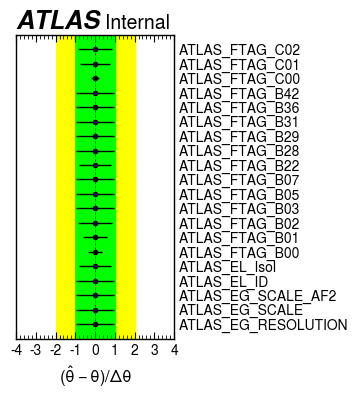

In [7]:
plot = PullPlot(data0.iloc[0:20])
plot.plot_options(rangelist=[-4, 4], center=0)
plot.figure_options(labelside='right')
plot.color_options(marker='black', onesigma='lime', twosigma='yellow')
plot.set_axislabels(12, xmain=r'$(\hat{\theta}-\theta)/\Delta\theta$')
plot.create()
# plot.saveimage("PullPlot_demo", 1000)